# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [3]:
data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)

df = pd.read_csv(data_folder + 'traffic.csv', header=None)
df = df[1:].astype('float').T

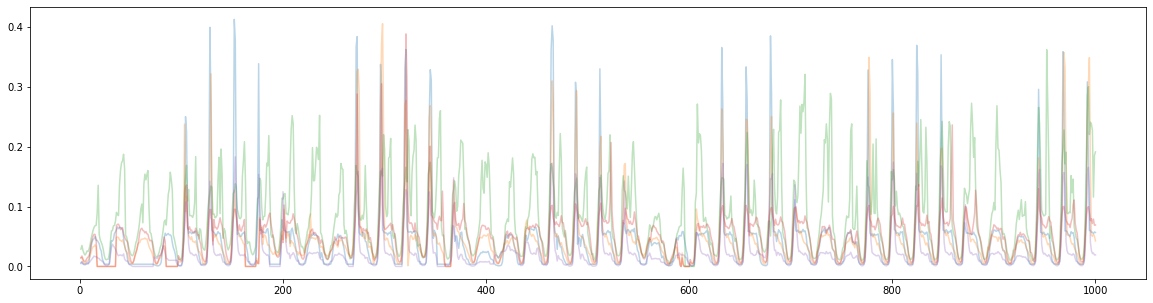

In [4]:
plt.figure(figsize=(20,5))
plt.plot(df.iloc[:5, :1000].T, alpha=.3)
plt.show()

In [5]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

### Special DataLoader for Traffic Data ###

In [6]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

import numpy as np
def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.) / (len(x)))

class DataLoaderH(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train, valid, horizon, window, normalize=2):
        """
        1.Get Data
        2. Normalize 
        3. Split
        """
        self.P = window
        self.h = horizon
        
        fin = open(file_name)
        self.rawdat = np.loadtxt(fin, delimiter=',')
        self.dat = np.zeros(self.rawdat.shape)

        self.n, self.m = self.dat.shape
        self.normalize = 2
        self.scale = np.ones(self.m)
        self.bias =  np.zeros(self.m)
        self._normalized(normalize)
        self._split(int(train * self.n), int((train + valid) * self.n), self.n)

        self.scale = torch.from_numpy(self.scale).float()
        self.bias = torch.from_numpy(self.bias).float()
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.h, self.m)

        self.scale = self.scale.cuda()
        self.scale = Variable(self.scale)
        self.bias = self.bias.cuda()
        self.bias = Variable(self.bias)

        tmp = tmp[:, -1, :].squeeze()
        self.rse = normal_std(tmp)
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)))

    def _normalized(self, normalize):
        """
        Normalize Data
        0. No Normalization
        1. MinMaxScaler - by one scaler
        2. MinMaxScaler - by each sensor
        3. StandardScaler - by each sensor
        """
        if (normalize == 0):
            self.dat = self.rawdat

        if (normalize == 1):
            # normalized by the maximum value of entire matrix.
            self.dat = self.rawdat / np.max(self.rawdat)
        
        if (normalize == 2):
            # normlized by the maximum value of each row (sensor).
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdat[:, i]))
                self.dat[:, i] = self.rawdat[:, i] / np.max(np.abs(self.rawdat[:, i]))

        if (normalize == 3):
            # normlized by the mean/std value of each row (sensor).
            for i in range(self.m):
                self.scale[i] = np.std(self.rawdat[:, i]) #std
                self.bias[i] = np.mean(self.rawdat[:, i])
                self.dat[:, i] = (self.rawdat[:, i] - self.bias[i]) / self.scale[i]


    def _split(self, train, valid, test):
        """
        Train-Valid-Test Split
        1. Make as Dataset
        2. Make as Loader
        """
        train_set = range(self.P + self.h - 1, train)
        valid_set = range(train, valid)
        test_set = range(valid, self.n)
        self.train = self._batchify(train_set, self.h)
        self.valid = self._batchify(valid_set, self.h)
        self.test = self._batchify(test_set, self.h)

    def _batchify(self, idx_set, horizon):
        n = len(idx_set)
        X = torch.zeros((n, self.P, self.m))
        Y = torch.zeros((n, self.h, self.m))
        for i in range(n):
            end = idx_set[i] - self.h + 1
            start = end - self.P
            X[i, :, :] = torch.from_numpy(self.dat[start:end, :])
            #Y[i, :, :] = torch.from_numpy(self.dat[idx_set[i] - self.h:idx_set[i], :])
            Y[i, :, :] = torch.from_numpy(self.dat[end:(idx_set[i]+1), :])
        return [X, Y]

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        """
        get Batch
        """
        length = len(inputs)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            X = inputs[excerpt]
            Y = targets[excerpt]
            X = X.cuda()
            Y = Y.cuda()
            yield Variable(X), Variable(Y)
            start_idx += batch_size

In [7]:
batch_size = 64
num_workers = 4
pin_memory = True
device = 'cuda'
num_epoch = 200
lr = 1e-4

In [8]:
train_ratio = 0.6
valid_ratio = 0.2
window = 168
pred_step = 1
normalize = 2

loader = DataLoaderH(data_folder+'traffic.txt', train_ratio, valid_ratio, pred_step, window, normalize)

# 2. Manual Attack

In [9]:
import copy
def offset(input_, offset=0.1, window=35, num_sample=1,
           random_noise=True, max_rand_noise=0.01, label_last_col=False, 
           multi_var=0, device=None):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...)
    offset: constant value in the range of 0-1, which will be plus added.
    window: time window to be attacked.
    num_sample: number of records to be attacked.
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start, and end]
    """
    x = copy.deepcopy(input_)
    assert window > 0 and window < x.shape[1], "Incorrect range of window"
    assert offset >= 0 and offset <= 1, "Incorrect range of offset value"
    if label_last_col==True:
        if len(x.shape)>2:
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else:
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]

    idxs = range(num_sample)
    start_idx = np.random.randint(0, x.shape[1]-window, num_sample)
    indices = np.stack((idxs, start_idx, start_idx + window), axis=1)    
    
    if multi_var != 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window, multi_var))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window, multi_var))
        for p, sensor_idx in enumerate(sensor_idxs):
            for j, [i, start_idx, end_idx] in enumerate(indices):
                x[i, start_idx:end_idx, sensor_idx] += torch.as_tensor(offset).to(device) + torch.Tensor(noise[j,:,p]).to(device)
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window))
        for j, [i, start_idx, end_idx] in enumerate(indices):
            x.iloc[i,start_idx:end_idx] += offset + noise[j,:]
            
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
    
        return x, indices
    
    
def drift(input_, scale=0.1, window=35, num_sample=1, type_='increasing', 
          random_noise=True, max_rand_noise=0.01, label_last_col=False,
          multi_var=0, device=None):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...)
    scale: constant value in the range of 0-1, which will be plus increasingly added.
    window: time window to be attacked.
    num_sample: number of records to be attacked.
    type: options consists of 'increasing' and 'decreasing'
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start, and end]
    """
    x = copy.deepcopy(input_)
    assert window > 0 and window < x.shape[1], "Incorrect range of window"
    assert scale >= 0 and scale <= 1, "Incorrect range of scale value"
    
    if label_last_col==True:
        if len(x.shape)>2:
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else:
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]
    idxs = range(num_sample)
    start_idx = np.random.randint(0, x.shape[1]-window, num_sample)
    if len(x.shape)<3:
        start_idx = np.random.randint(0, x.shape[1]//2, num_sample)
    indices = np.stack((idxs, start_idx, start_idx + window), axis=1)

    if multi_var > 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window, multi_var))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window, multi_var))
        f = np.linspace(start=0, stop=scale, num=window) 
        if type_ =='decreasing':
            f = -f
        for p, sensor_idx in enumerate(sensor_idxs):
            for j, [i, start_idx, end_idx] in enumerate(indices):
                x[i, start_idx:end_idx, sensor_idx] += torch.Tensor(f).to(device) + torch.Tensor(noise[j,:,p]).to(device)
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        if random_noise == True:
            noise = np.random.normal(0, max_rand_noise, size=(len(idxs), window))
            noise = np.around(noise,6)
        else:
            noise = np.zeros(shape=(len(idxs), window))
        f = np.linspace(start=0, stop=scale, num=window) 
        if type_ =='decreasing':
            f = -f
        for j, [i, start_idx, end_idx] in enumerate(indices):
            x.iloc[i, start_idx:end_idx] += f + noise[j,:]
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
        return x, indices
    

def lagging(input_, lag_time=15, num_sample=1, multi_var=0, type_='backward',
            random_noise=True, max_rand_noise=0.01, label_last_col=False, device=None):
    """
    input: pandas dataframe, its axis must be matched like (time, variable, ...).
    lag_time: integer which is lagging duration.
    num_sample: number of records to be attacked.
    random_noise: adding brownian motion random noise.
    max_rand_noise: maximum random noise.
    label_last_col: whether last column is target label or not.
    multi_var: number of multivariate sensors to be attacked.
    return: normalized x, [attacked sample indices, time indices for start]
    """
    x = copy.deepcopy(input_)
    assert lag_time >= 0, "Incorrect range of lag time"
#     assert type(lag_time) is int, "Incorrect data type of lag time"
    if label_last_col==True:
        if len(x.shape)>2: # multivariate
            label_col = x[:,-1,:]
            x = x[:,:-1,:]
        else: #univariate
            label_col = x.iloc[:,-1]
            x = x.iloc[:,:-1]
    
    idxs = range(num_sample)
    if type_=='backward':
        start_idx = np.random.randint(lag_time, x.shape[1]-2*lag_time, num_sample)
        if len(x.shape)<3:
            start_idx = np.random.randint(lag_time, x.shape[1]//2, num_sample)
    else: # 'forward'
        start_idx = np.random.randint(2*lag_time, x.shape[1]-lag_time, num_sample)
        if len(x.shape)<3:
            start_idx = np.random.randint(lag_time, x.shape[1]//2, num_sample)
    indices = np.stack((idxs, start_idx), axis=1)            
    if multi_var > 0: # multivariate (PeMS) [samples, time, sensor] =(10358, 168, 862)
        assert multi_var >= 0 and multi_var < x.shape[2], "Incorrect number of multivariate sensors to be attacked"
        sensor_idxs = np.random.randint(0, x.shape[2], multi_var)
        
        for _, [i, start_idx] in enumerate(indices):
            if type_=='backward':
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                for p, sensor_idx in enumerate(sensor_idxs): 
                    x[i,start_idx:x.shape[1],sensor_idx] = copy.deepcopy(x[i,start_idx-lag_time:x.shape[1]-lag_time,sensor_idx])
                    x[i,start_idx-lag_time:start_idx,sensor_idx] = copy.deepcopy(x[i,start_idx-lag_time,sensor_idx])
                    x[i,start_idx-lag_time:x.shape[1],sensor_idx] += torch.Tensor(noise[:,p]).to(device)
            else: # 'forward'
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x[i,start_idx-lag_time:x.shape[1],0].shape[0], multi_var))
                for p, sensor_idx in enumerate(sensor_idxs): 
                    x[i,start_idx-lag_time:x.shape[1]-lag_time,sensor_idx] = x[i,start_idx:x.shape[1],sensor_idx]
                    x[i,x.shape[1]-lag_time:x.shape[1],sensor_idx] = x[i,x.shape[1]-lag_time,sensor_idx]
                    x[i,start_idx-lag_time:x.shape[1],sensor_idx] += torch.Tensor(noise[:,p]).to(device)
#         x = x.clamp(min=0.0, max=1.0) # clipping 0 through 1
        if label_last_col==True:
            x = torch.cat((x, label_col.unsqueeze(1)), 1)
        return x, indices, sensor_idxs
    
    else: #univariate (ECG) [sample, time] =(21892, 188)
        for _, [i, start_idx] in enumerate(indices):
            if type_=='backward':
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x.iloc[i,start_idx-lag_time:x.shape[1]].shape[0]))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x.iloc[i,start_idx-lag_tim:x.shape[1]].shape[0]))
                x.iloc[i,start_idx-lag_time:x.shape[1]] = x.iloc[i,start_idx-lag_time:x.shape[1]].shift(periods=lag_time, fill_value=x.iloc[i,start_idx-lag_time])
                x.iloc[i,start_idx-lag_time:x.shape[1]] += noise
            else:
                if random_noise == True:
                    noise = np.random.normal(0, max_rand_noise, size=(x.iloc[i,start_idx:x.shape[1]].shape[0]))
                    noise = np.around(noise,6)
                else:
                    noise = np.zeros(shape=(x.iloc[i,start_idx:x.shape[1]].shape[0]))
                x.iloc[i,start_idx:x.shape[1]] = x.iloc[i,start_idx:x.shape[1]].shift(periods=-lag_time-1, fill_value=0)
                x.iloc[i,start_idx:x.shape[1]] += noise     
        x.clip(lower=0.0, upper=1.0, inplace=True) # clipping 0 through 1
        if label_last_col==True:
            x = pd.concat([x,label_col],axis=1)
        return x, indices

In [10]:
data = loader
X_test = data.test[0].to(device)
Y_test = data.test[1].to(device)

offsets, offset_idx, offset_sensor_idx        = offset(X_test, offset=0.1, window=45, num_sample=X_test.shape[0],
                                                   max_rand_noise=0.005, label_last_col=False, multi_var=2, device=device)
increasing, increase_idx, increase_sensor_idx = drift(X_test, scale=0.1, window=45, num_sample=X_test.shape[0], type_='increasing',
                                                   max_rand_noise=0.005, label_last_col=False, multi_var=2, device=device)
decreasing, decrease_idx, decrease_sensor_idx = drift(X_test, scale=0.1, window=45, num_sample=X_test.shape[0], type_='decreasing',
                                                 max_rand_noise=0.005, label_last_col=False, multi_var=2, device=device)
backward, backward_idx, backward_sensor_idx   = lagging(X_test, lag_time=3, num_sample=X_test.shape[0], type_="backward",
                                                   max_rand_noise=0.005, label_last_col=False, multi_var=2, device=device)
forward, forward_idx, forward_sensor_idx      = lagging(X_test, lag_time=3, num_sample=X_test.shape[0], type_="forward",
                                                   max_rand_noise=0.005, label_last_col=False, multi_var=2, device=device)

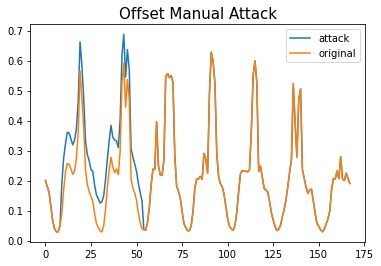

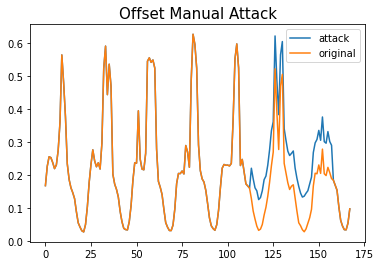

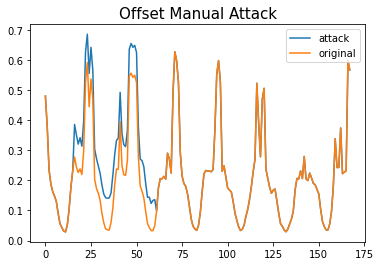

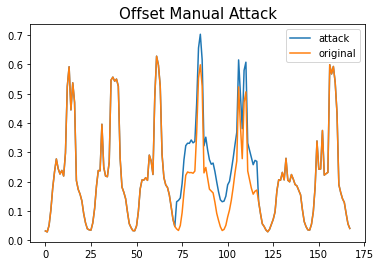

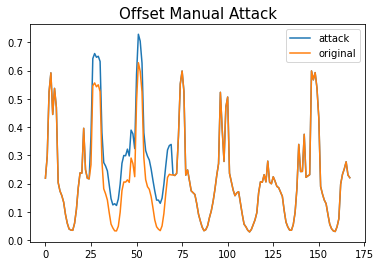

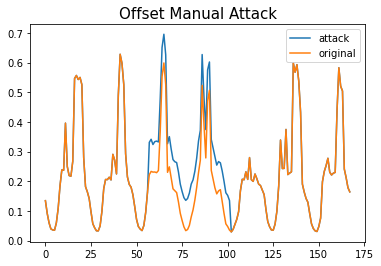

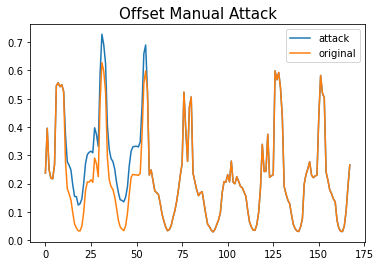

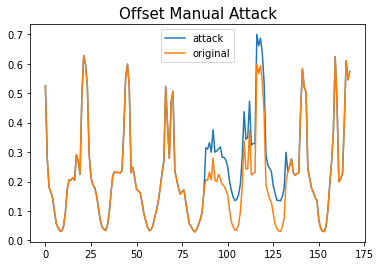

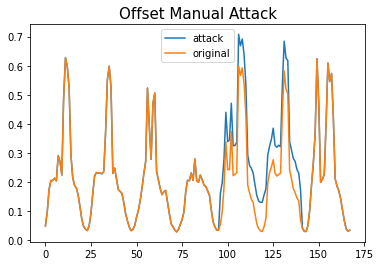

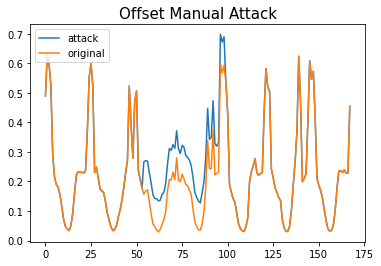

In [11]:
for i in range(0,100, 10):
    plt.plot(pd.DataFrame(offsets[i, :, offset_sensor_idx[0]].detach().cpu().numpy()), label='attack') 
    plt.plot(pd.DataFrame(X_test[i, :, offset_sensor_idx[0]].detach().cpu().numpy()), label='original')
    plt.legend()
    plt.title("Offset Manual Attack", fontsize=15)
    plt.show()

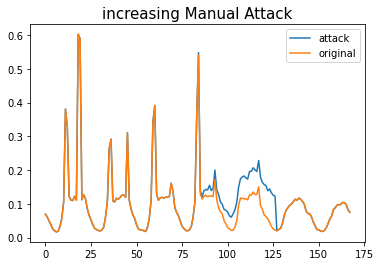

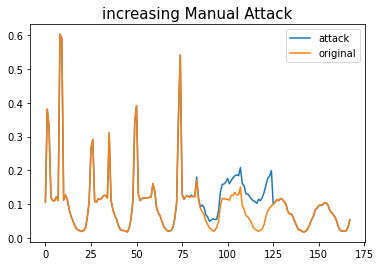

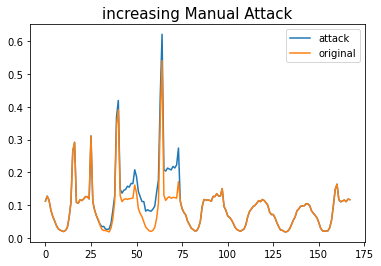

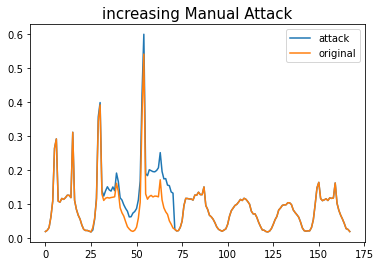

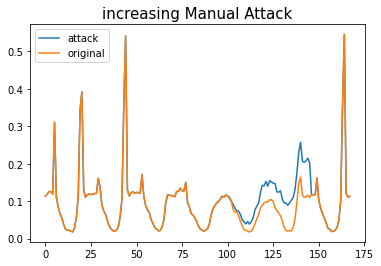

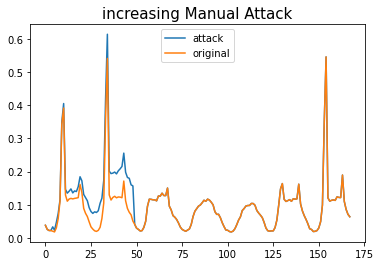

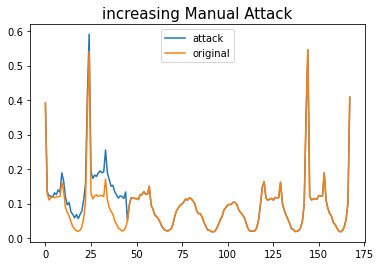

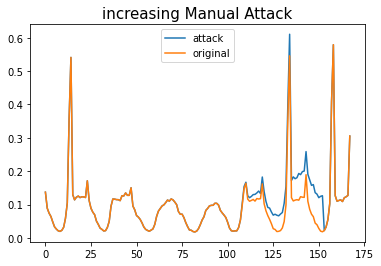

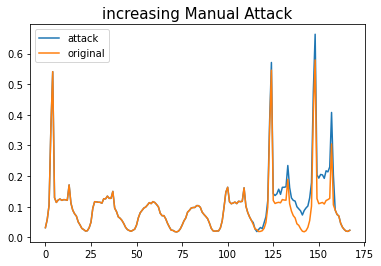

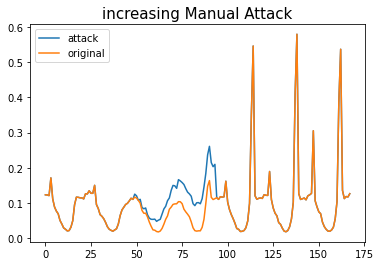

In [12]:
for i in range(0,100, 10):
    plt.plot(pd.DataFrame(increasing[i, :, increase_sensor_idx[0]].detach().cpu().numpy()), label='attack') 
    plt.plot(pd.DataFrame(X_test[i, :, increase_sensor_idx[0]].detach().cpu().numpy()), label='original')
    plt.legend()
    plt.title("increasing Manual Attack", fontsize=15)
    plt.show()

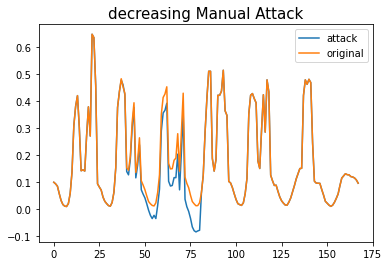

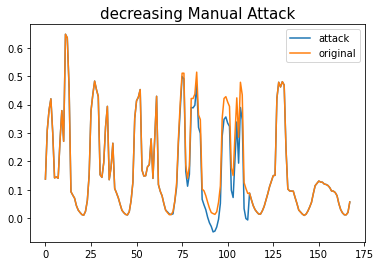

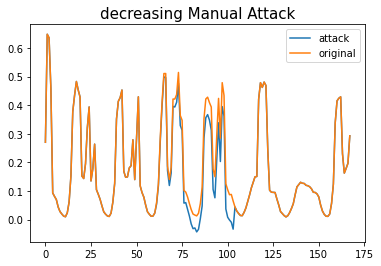

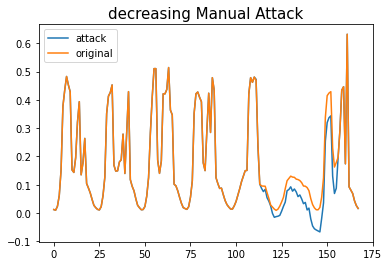

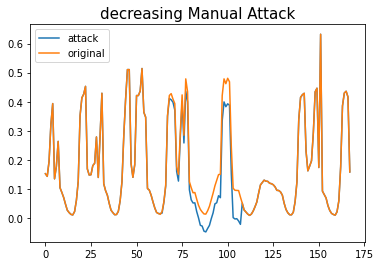

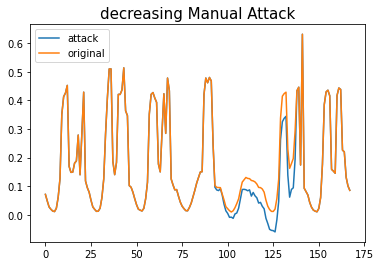

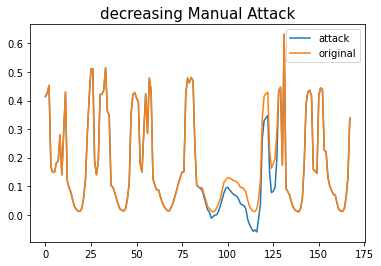

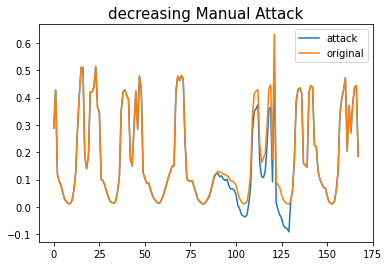

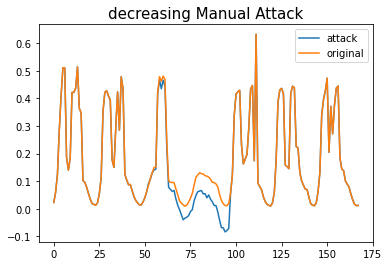

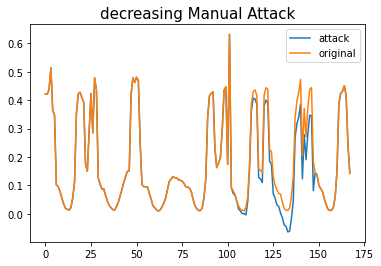

In [13]:
for i in range(0,100, 10):
    plt.plot(pd.DataFrame(decreasing[i, :, decrease_sensor_idx[0]].detach().cpu().numpy()), label='attack') 
    plt.plot(pd.DataFrame(X_test[i, :, decrease_sensor_idx[0]].detach().cpu().numpy()), label='original')
    plt.legend()
    plt.title("decreasing Manual Attack", fontsize=15)
    plt.show()

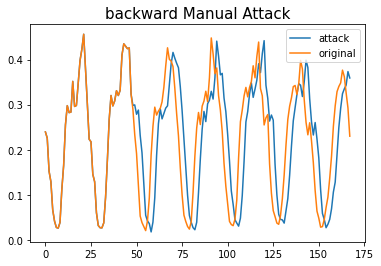

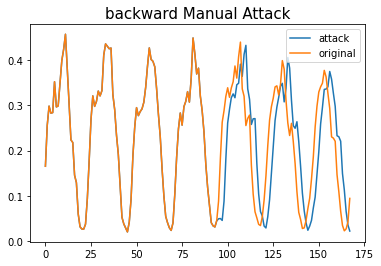

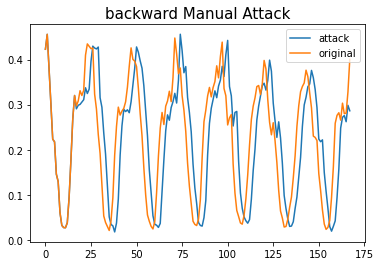

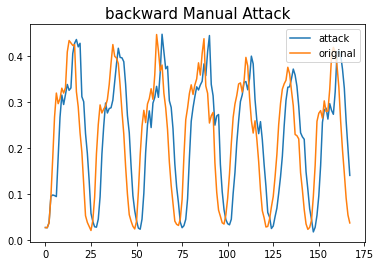

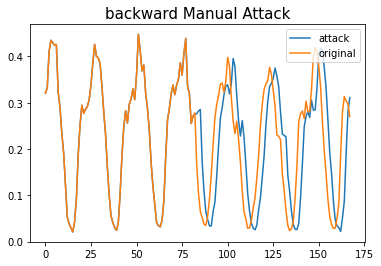

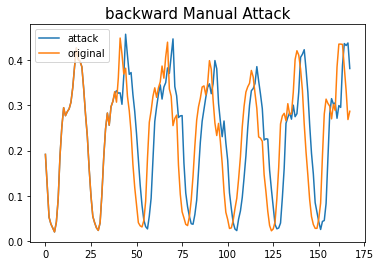

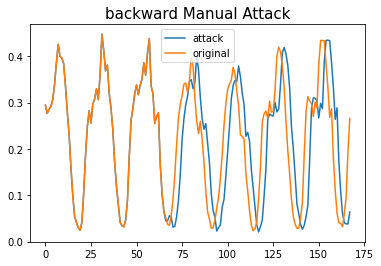

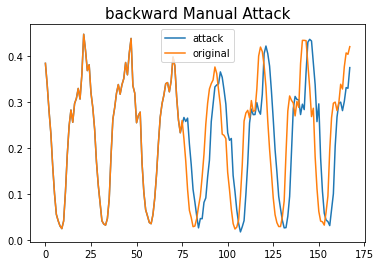

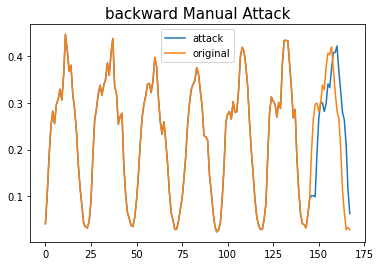

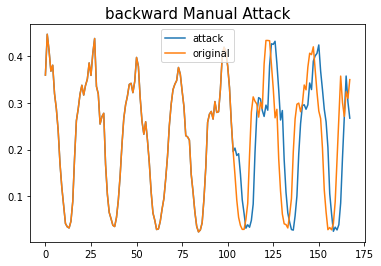

In [14]:
for i in range(0,100, 10):
    plt.plot(pd.DataFrame(backward[i, :, backward_sensor_idx[0]].detach().cpu().numpy()), label='attack') 
    plt.plot(pd.DataFrame(X_test[i, :, backward_sensor_idx[0]].detach().cpu().numpy()), label='original')
    plt.legend()
    plt.title("backward Manual Attack", fontsize=15)
    plt.show()

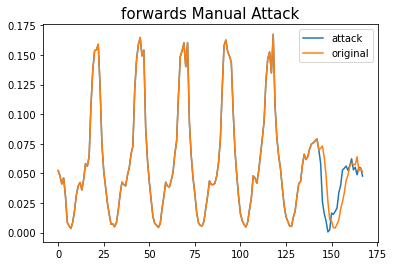

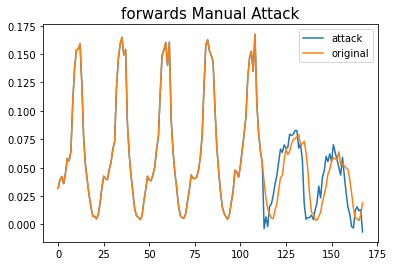

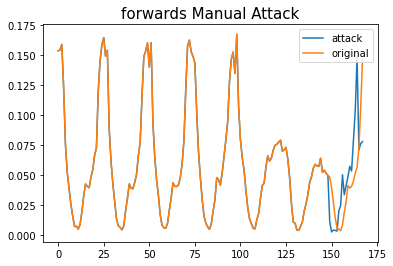

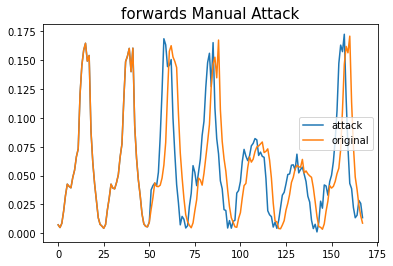

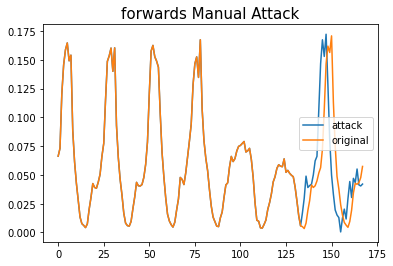

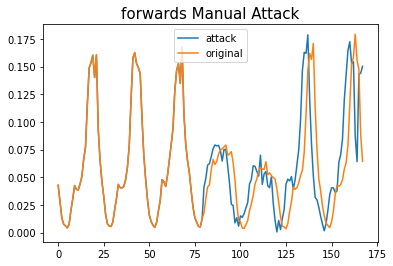

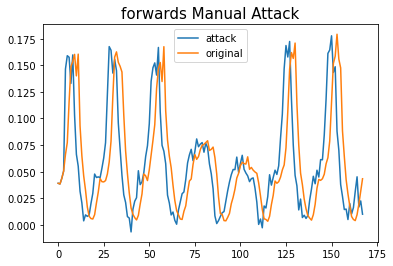

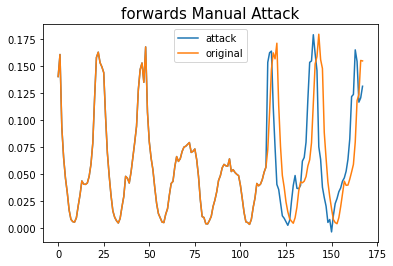

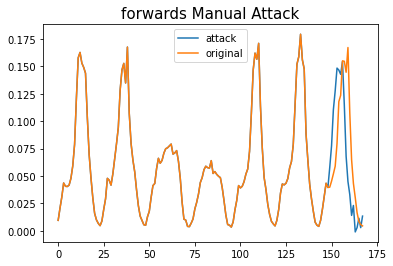

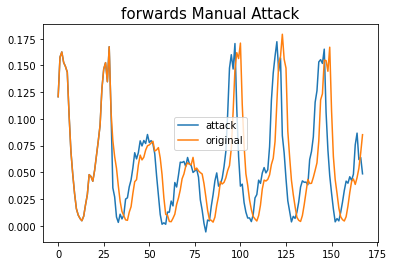

In [15]:
for i in range(0,100, 10):
    plt.plot(pd.DataFrame(forward[i, :, forward_sensor_idx[0]].detach().cpu().numpy()), label='attack') 
    plt.plot(pd.DataFrame(X_test[i, :, forward_sensor_idx[0]].detach().cpu().numpy()), label='original')
    plt.legend()
    plt.title("forwards Manual Attack", fontsize=15)
    plt.show()

## Save

In [16]:
import pickle

data_dict = {
    'data': offsets,
    'idx': offset_idx,
    'sensor_idx': offset_sensor_idx
}

with open(data_folder+'traffic_offsetAttack.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
    
with open(data_folder+'traffic_offsetAttack.pkl', 'rb') as f:
    data = pickle.load(f)
    
X_test = data['data'].to(device)
print(X_test.shape)

torch.Size([3509, 168, 862])


In [17]:
data_dict = {
    'data': increasing,
    'idx': increase_idx,
    'sensor_idx': increase_sensor_idx
}

with open(data_folder+'traffic_increaseAttack.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
    
with open(data_folder+'traffic_increaseAttack.pkl', 'rb') as f:
    data = pickle.load(f)
    
X_test = data['data'].to(device)
print(X_test.shape)

torch.Size([3509, 168, 862])


In [18]:
data_dict = {
    'data': decreasing,
    'idx': decrease_idx,
    'sensor_idx': decrease_sensor_idx
}

with open(data_folder+'traffic_decreaseAttack.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
    
with open(data_folder+'traffic_decreaseAttack.pkl', 'rb') as f:
    data = pickle.load(f)
    
X_test = data['data'].to(device)
print(X_test.shape)

torch.Size([3509, 168, 862])


In [19]:
data_dict = {
    'data': backward,
    'idx': backward_idx,
    'sensor_idx': backward_sensor_idx
}

with open(data_folder+'traffic_backwardAttack.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
    
with open(data_folder+'traffic_backwardAttack.pkl', 'rb') as f:
    data = pickle.load(f)
    
X_test = data['data'].to(device)
print(X_test.shape)

torch.Size([3509, 168, 862])


In [20]:
data_dict = {
    'data': forward,
    'idx': forward_idx,
    'sensor_idx': forward_sensor_idx
}

with open(data_folder+'traffic_forwardAttack.pkl', 'wb') as f:
    pickle.dump(data_dict, f)
    
with open(data_folder+'traffic_forwardAttack.pkl', 'rb') as f:
    data = pickle.load(f)
    
X_test = data['data'].to(device)
print(X_test.shape)

torch.Size([3509, 168, 862])
